<a href="https://colab.research.google.com/github/hrbae/LG_AI_training/blob/main/M1_Proces_Innovationby_ML/Practice_1_3_Remaining_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**3. Remaining Time Prediction**

In [1]:
# 필요 라이브러리 호출
import io
import os
import json
import argparse
import time
import numpy as np
import pandas as pd
import datetime


import time

import torch
import torch.nn as nn

from pickle import TRUE
from sklearn import utils
from tqdm import tqdm as tqdm
from sklearn import utils
from sklearn import metrics 
from sklearn import preprocessing 
import warnings
warnings.filterwarnings('ignore')

print("GPU Condition", torch.cuda.is_available()) # True/False

GPU Condition True


#**Data Description**
 - 이탈리아 S/W 회사의 헬프데스크 티켓팅 관리 프로세스 데이터(https://data.4tu.nl/articles/dataset/Dataset_belonging_to_the_help_desk_log_of_an_Italian_Company/12675977)
 - 21,348 events, 4,580 cases, 14 activities
 - Case ID: the case identifier
 - Activity: the activity name
 - Resource: the resource who performed the action
 - Complete Timestamp: the timestamp of the event. Format: YYYY/MM/DD hh:mm:ss.sss



In [ ]:
#실습용 데이터 호출
df = pd.read_csv('https://raw.githubusercontent.com/yongzzai/LGPracticum/main/helpdesk.csv')

In [3]:
df

,Case ID,Activity,Resource,Complete Timestamp,Variant,Variant index,Variant.1,seriousness,customer,product,responsible_section,seriousness_2,service_level,service_type,support_section,workgroup
0,Case 1,Assign seriousness,Value 1,2012/10/09 14:50:17.000,Variant 12,12,Variant 12,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1
1,Case 1,Take in charge ticket,Value 1,2012/10/09 14:51:01.000,Variant 12,12,Variant 12,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1,Value 1
2,Case 1,Take in charge ticket,Value 2,2012/10/12 15:02:56.000,Variant 12,12,Variant 12,Value 1,Value 1,Value 1,Value 1,Value 1,Value 2,Value 1,Value 1,Value 1
3,Case 1,Resolve ticket,Value 1,2012/10/25 11:54:26.000,Variant 12,12,Variant 12,Value 1,Value 1,Value 1,Value 1,Value 1,Value 2,Value 1,Value 1,Value 1
4,Case 1,Closed,Value 3,2012/11/09 12:54:39.000,Variant 12,12,Variant 12,Value 1,Value 1,Value 1,Value 1,Value 1,Value 2,Value 1,Value 1,Value 1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21343,Case 4579,Closed,Value 5,2010/09/02 10:11:00.000,Variant 1,1,Variant 1,Value 1,Value 71,Value 3,Value 1,Value 1,Value 3,Value 1,Value 1,Value 1
21344,Case 4580,Take in charge ticket,Value 6,2012/01/03 09:33:43.000,Variant 18,18,Variant 18,Value 1,Value 92,Value 3,Value 1,Value 2,Value 2,Value 2,Value 1,Value 1
21345,Case 4580,Wait,Value 6,2012/01/10 15:30:11.000,Variant 18,18,Variant 18,Value 1,Value 92,Value 3,Value 1,Value 2,Value 2,Value 2,Value 1,Value 1
21346,Case 4580,Resolve ticket,Value 6,2012/01/10 17:07:40.000,Variant 18,18,Variant 18,Value 1,Value 92,Value 3,Value 1,Value 2,Value 2,Value 2,Value 1,Value 1


In [4]:
#필요한 column에 대해 필터링
df = df[['Case ID', 'Activity', 'Complete Timestamp', 'Resource']]
df.columns = ["Case", "Activity", "Timestamp", 'Resource']

In [5]:
df

,Case,Activity,Timestamp,Resource
0,Case 1,Assign seriousness,2012/10/09 14:50:17.000,Value 1
1,Case 1,Take in charge ticket,2012/10/09 14:51:01.000,Value 1
2,Case 1,Take in charge ticket,2012/10/12 15:02:56.000,Value 2
3,Case 1,Resolve ticket,2012/10/25 11:54:26.000,Value 1
4,Case 1,Closed,2012/11/09 12:54:39.000,Value 3
...,...,...,...,...
21343,Case 4579,Closed,2010/09/02 10:11:00.000,Value 5
21344,Case 4580,Take in charge ticket,2012/01/03 09:33:43.000,Value 6
21345,Case 4580,Wait,2012/01/10 15:30:11.000,Value 6
21346,Case 4580,Resolve ticket,2012/01/10 17:07:40.000,Value 6


In [6]:
#Activity value를 소문자로 변환, 공백을 '-'처리
df["Activity"] = df["Activity"].str.lower()
df["Activity"] = df["Activity"].str.replace(" ", "-")

#Timestamp를 '/'에서 '-'로 변환, Datetime 형식으로 변환
df["Timestamp"] = df["Timestamp"].str.replace("/", "-")
df["Timestamp"]= pd.to_datetime(df["Timestamp"], dayfirst=True).map(lambda x: x.strftime("%Y-%m-%d %H:%M:%S"))
df.sort_values(by = ["Timestamp"], inplace = True)

In [7]:
df

,Case,Activity,Timestamp,Resource
16857,Case 3608,assign-seriousness,2010-01-13 08:40:25,Value 2
12863,Case 2748,assign-seriousness,2010-01-13 12:26:04,Value 2
19959,Case 4284,assign-seriousness,2010-01-13 12:30:37,Value 2
7168,Case 1534,assign-seriousness,2010-01-13 13:09:31,Value 2
1864,Case 406,assign-seriousness,2010-01-13 17:25:25,Value 2
...,...,...,...,...
5364,Case 1156,closed,2014-01-03 10:02:38,Value 3
14090,Case 3013,closed,2014-01-03 10:03:58,Value 3
18008,Case 3857,closed,2014-01-03 10:08:18,Value 3
12105,Case 2585,closed,2014-01-03 13:19:48,Value 3


In [8]:
# Map activities and resources 딕셔너리 생성,"metadata.json"로 저장
keys = ["[PAD]", "[UNK]"]
activities = list(df["Activity"].unique())
resources = list(df["Resource"].unique())
resources = list(map(str, resources))

keys.extend(activities)
val = range(len(keys))

coded_activity = dict({"x_word_dict":dict(zip(keys, val))})
code_activity_normal = dict({"y_word_dict": dict(zip(activities, range(len(activities))))})
code_resource_normal = dict({"x2_word_dict": dict(zip(resources, range(len(resources))))})

coded_activity.update(code_activity_normal)
coded_activity.update(code_resource_normal)

coded_json = json.dumps(coded_activity)
with open(f"metadata.json", "w") as metadata_file:
    metadata_file.write(coded_json)

In [9]:
#Train_test 80:20 비율로 나누기
train_test_ratio = int(abs(df["Case"].nunique()*0.80))
train_list = df["Case"].unique()[:train_test_ratio]
test_list = df["Case"].unique()[train_test_ratio:]

In [10]:
#Initialization
case_id = "Case"
event_name = "Activity"
event_time = "Timestamp"
processed_df = pd.DataFrame(columns = ["case_id", "prefix", "k", "time_passed", "recent_time", "latest_time","remaining_time_days"])
idx = 0
unique_cases = df[case_id].unique()


for _, case in enumerate(tqdm(unique_cases)):
    #Retrieve the list of activities from a single trace and convert it into a list format.
    act = df[df[case_id] == case][event_name].to_list()
    #Retrieve the list of timestamp from a single trace and convert it into a list format.
    time = df[df[case_id] == case][event_time].str[:19].to_list()
    #Initialization
    time_passed = 0
    latest_diff = datetime.timedelta()
    recent_diff = datetime.timedelta()
    for i in range(0, len(act)):
        #Build prefix
        prefix = np.where(i == 0, act[0], " ".join(act[:i+1]))
        #Compute the process k1 time as an independent variable feature.
        if i > 0:
            latest_diff = datetime.datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S") - \
                                datetime.datetime.strptime(time[i-1], "%Y-%m-%d %H:%M:%S")
        #Compute the process k2 time as an independent variable feature.
        if i > 1:
            recent_diff = datetime.datetime.strptime(time[i], "%Y-%m-%d %H:%M:%S")- \
                            datetime.datetime.strptime(time[i-2], "%Y-%m-%d %H:%M:%S")

        latest_time = np.where(i == 0, 0, latest_diff.days)
        recent_time = np.where(i <=1, 0, recent_diff.days)

        #Compute the time passed as an independent variable feature.
        time_passed = time_passed + latest_time

        #Compute the remaining time as an target variable.
        time_stamp = str(np.where(i == 0, time[0], time[i]))
        ttc = datetime.datetime.strptime(time[-1], "%Y-%m-%d %H:%M:%S") - \
                datetime.datetime.strptime(time_stamp, "%Y-%m-%d %H:%M:%S")
        ttc = str(ttc.days)  

        #create instance
        processed_df.at[idx, "case_id"]  = case
        processed_df.at[idx, "prefix"]  =  prefix
        processed_df.at[idx, "k"] = i
        processed_df.at[idx, "time_passed"] = time_passed
        processed_df.at[idx, "recent_time"] = recent_time
        processed_df.at[idx, "latest_time"] =  latest_time
        processed_df.at[idx, "remaining_time_days"] = ttc
        idx = idx + 1

100%|██████████| 4580/4580 [00:45<00:00, 101.00it/s]


In [11]:
processed_df.rename(columns={"k" : "seq"}, inplace=True)

In [12]:
#train/test data 나눠서 저장
train_df = processed_df[processed_df["case_id"].isin(train_list)]
test_df = processed_df[processed_df["case_id"].isin(test_list)]
train_df.to_csv(f"train.csv", index = False)
test_df.to_csv(f"test.csv", index = False)

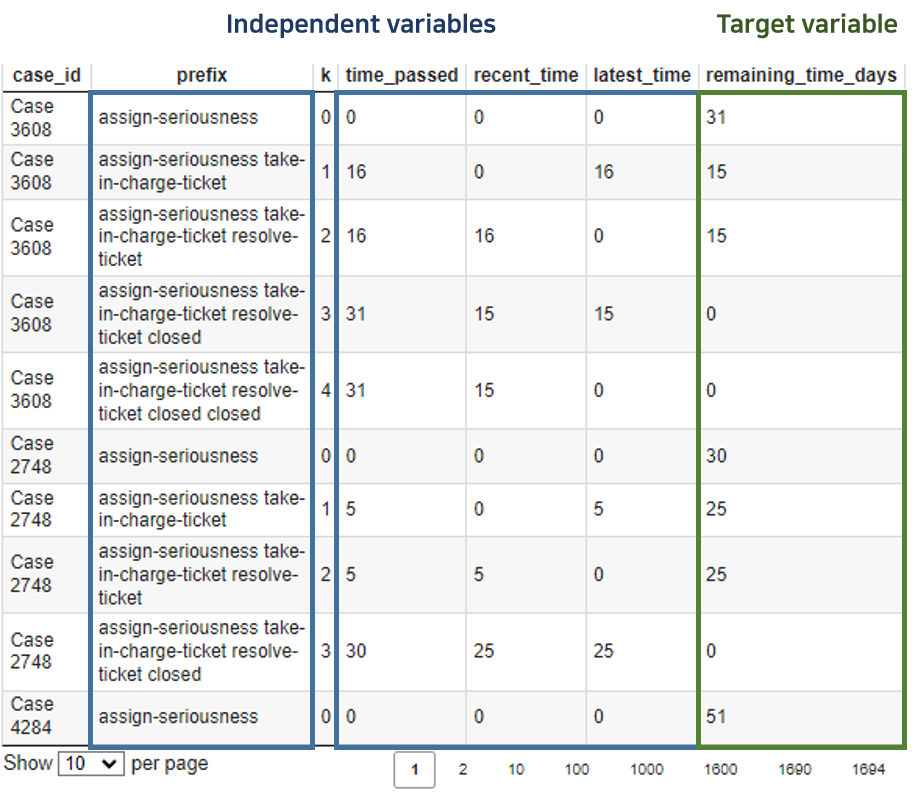

# **Vectorizing Data**

In [13]:
activities = list(df["Activity"].unique())
activ_encoding = dict(zip(activities, range(1, len(activities)+1) ))

ids = list(processed_df["case_id"].unique())
id_encoding = dict(zip(ids, range(1, len(ids)+1)))

def last_elem(row):
    return activ_encoding[str(row).split(" ")[-1]]

def vetorize(df):
    df["case_id"] = df["case_id"].map(id_encoding)
    df["prefix"] = df["prefix"].apply(lambda x : last_elem(x))
    return df

train_df = vetorize(train_df)
test_df = vetorize(test_df)

In [14]:
train_df

,case_id,prefix,seq,time_passed,recent_time,latest_time,remaining_time_days
0,1,1,0,0,0,0,31
1,1,2,1,16,0,16,15
2,1,3,2,16,16,0,15
3,1,6,3,31,15,15,0
4,1,6,4,31,15,0,0
...,...,...,...,...,...,...,...
16932,3663,6,3,36,15,15,0
16933,3664,1,0,0,0,0,46
16934,3664,2,1,1,0,1,44
16935,3664,3,2,9,9,8,36


# **Time Window Dataset**

In [15]:
from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, df, input_window, output_window) -> None:
        super().__init__()
        
        self.Xs = []
        self.ys = []
        for id in df["case_id"].unique():
            df_mini = df.loc[df["case_id"] == id, :]
            
            if df_mini.shape[0] > input_window+output_window:
                for r_idx in range(input_window, df_mini.shape[0]-output_window-input_window+1):
                    X = df_mini.iloc[r_idx-input_window:r_idx, :-1]
                    y = df_mini.iloc[r_idx, -1]
                    self.Xs.append(X.values)
                    # print(X.values)
                    self.ys.append(int(y))
                    
        self.Xs = torch.FloatTensor(self.Xs)
        self.ys = torch.FloatTensor(self.ys)

    def __getitem__(self, index):
        return self.Xs[index], self.ys[index] 

    def __len__(self):
        return len(self.Xs)

input_window = 3
output_window = 1

trainDataset = TimeSeriesDataset(train_df, input_window=input_window, output_window=output_window)
testDataset = TimeSeriesDataset(test_df, input_window=input_window, output_window=output_window)

trainLoader = DataLoader(trainDataset, batch_size=256)
testLoader = DataLoader(testDataset, batch_size=256)

## GRU(Gated Recurrent Unit)
----
*   RNN(순환신경망)의 장기의존성문제를 해결하기 위해 고안
*   Update gate, Reset Gate로 이루어짐
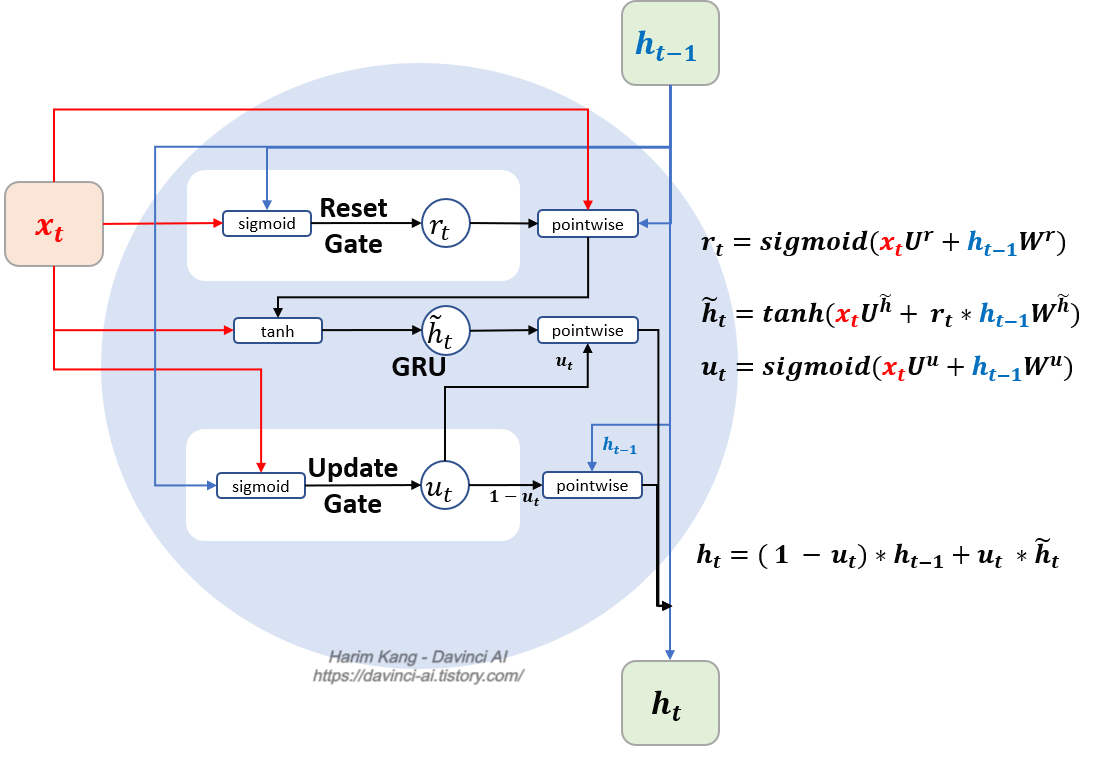

In [16]:
class GRU_model(nn.Module):
    def __init__(self, num_feat, num_layer, hidden_size, drop_p, seq_len, output_dim) -> None:
        super().__init__()
        self.GRU = nn.GRU(
            input_size = num_feat,
            num_layers = num_layer,
            hidden_size = hidden_size,
            batch_first = True,
            dropout = drop_p
        )
        self.linear_squeeze_x = nn.Linear(hidden_size, 1)
        self.linear_squeeze_y = nn.Linear(seq_len, output_dim)
    
    def forward(self, X):
        X, _ = self.GRU(X)
        X = self.linear_squeeze_x(X).squeeze(-1)
        out = self.linear_squeeze_y(X).squeeze(-1)
        
        return out

In [17]:
device = "cuda"

Test function

In [18]:
def test(loader, model):

    model.eval()
    # labels = []
    # preds = []
    labels = np.array([])
    preds = np.array([])

    with torch.no_grad():
        for idx, (X, y) in enumerate(loader):
            X, y = X.to(device), y.to(device)
            pred = model(X)

            labels = np.append(labels, y.to("cpu").numpy())
            preds = np.append(preds, pred.to("cpu").numpy())
            # print(labels.shape, preds.shape)
    return labels, preds

Train function

In [19]:
from sklearn.metrics import mean_squared_error

def train(train_loader, testLoader, optim, loss_fn, epoch, model, early_stop):

    loop = tqdm(range(epoch))

    model.train()
    prev_error = 0
    stop_count = 0
    for epoch in loop:
        running_loss = 0
        for idx, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            optim.zero_grad()

            pred = model(X)
            # print(y.shape, pred.shape)
            # print(y)

            loss = loss_fn(y, pred)
            loss.backward()
            optim.step()
            running_loss += loss.item()
        loop.set_description(f"loss - {running_loss/len(train_loader)}")
        
        if epoch % 5 == 0 :
            label, preds = test(testLoader, model)
            model.train()
            error = mean_squared_error(label, preds)
            if error > prev_error :
                stop_count += 1
            else :
                stop_count = 0
            prev_error = error

        if stop_count == early_stop:
            break

    print("Done training")

In [36]:
model = GRU_model(num_feat=train_df.shape[1]-1, num_layer=2, hidden_size=256, drop_p=0.25, seq_len=input_window, output_dim=output_window)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
epoch = 500

train(trainLoader, testLoader, optimizer, loss_fn, epoch, model.to(device), early_stop=6)

loss - 64.77585029602051: 100%|██████████| 500/500 [00:05<00:00, 98.97it/s] 

Done training


In [37]:
label, prediction = test(testLoader, model)

In [38]:
#mse
print(mean_squared_error(label, prediction))

60.67154344868536


In [39]:
#mae
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(label, prediction))

6.45379290373429
